#3D Data Transformation
---------------------------
By : Juan C. Peña and Eberto Benjumea

**(Pending documentation)**

------------------------------------
# Installing dependences

In [ ]:
#@title
%%capture
!pip install deeptrack

In [ ]:
#@title
%%capture
!pip install geopandas

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
import cv2
import random
import scipy.io
%matplotlib inline
import numpy as np
import deeptrack as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import img_as_float
from shapely.geometry import Point
from matplotlib.patches import Rectangle
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [ ]:
#@title
class Preprocessor():

  def __init__(self,
               scales=[1, 2, 4]
               ):
    self.scales = scales

  
  def crop(self, image, x, y, wide):
    cropped_image = image[y: y + wide, x: x + wide]

    return cropped_image

  def normalizate(self, image):
    normalized_image = (image - np.quantile(image, 0.01))/ (np.quantile(image, 0.99) - np.quantile(image, 0.01))
    # NaN detection
    nan_mask = np.isnan(normalized_image)
    normalized_image[nan_mask] = 0
    
    return normalized_image

  def resize(self, image, scale):
    resized_image = cv2.resize(image, (0, 0), fx=1/scale, fy=1/scale)

    return resized_image

  def generate_pipeline(self, data, transformations):
    pipeline = None
    for transformation in transformations:
        if pipeline is None:
            pipeline = transformation
        else:
            pipeline = pipeline >> transformation

    return pipeline

  def create_train_data(self, data, transformations):
    # data -> an image o a list of images
    normalized_images = [self.normalizate(image) for image in data]
    training_images = [np.expand_dims(image, axis = -1) for image in normalized_images]

    pipeline = self.generate_pipeline(training_images, transformations)
    train_set = dt.Value(lambda: np.array(random.choice(training_images))) >> pipeline
    train_set.plot()

    return train_set

  def load_images(self, data, plot=True):
    dataset = [self.resize(data, scale) for scale in self.scales]
    input_set = [self.normalizate(image) for image in dataset]

    if plot:
      fig, ax = plt.subplots(1, len(input_set), figsize=(25,5))
      fig.tight_layout()
      fig.suptitle('Scaled 3D images')
      for index in range(len(input_set)):
        ax[index].imshow(input_set[index])
    
    return input_set

# --------------------------------------------------------------------
class Trainer():

  def __init__(self,
               filepath,
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               callbacks = [None]
               ):

    self.model = model
    self.filepath = filepath
    self.callbacks = [
        ModelCheckpoint(filepath=self.filepath,
                        save_weights_only=True,
                        monitor='consistency_loss',
                        mode='min',
                        save_best_only=True
                        ),
        EarlyStopping(monitor="total_loss",
                      patience=15,
                      verbose=1,
                      mode="auto",
                      restore_best_weights=True
                      ),
        LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))
    ]
  
  def fit(self, train_set, epochs=40, batch_size=8):
    history = self.model.fit(
        train_set,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = self.callbacks)

    return history

  def plot_performance(self, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    fig.suptitle('Total loss and consistency loss')

    ax1.plot(history.history['total_loss'])
    ax1.set_title('Total loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_ylim([0, 1.5])

    ax2.plot(history.history['consistency_loss'])
    ax2.set_title('Consitency loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.set_ylim([0, 1.5])

    plt.show()

# --------------------------------------------------------------------
class Detector():

  def __init__(self,
               downsample,
               alpha = 0.1,
               cutoff = 0.998,
               mode = "quantile",
               colors = 'rgb',
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               ):
    self.downsample = downsample
    self.alpha = alpha
    self.cutoff = cutoff
    self.mode = mode
    self.colors = colors
    self.model = model

  def detect(self, image, plot=True):
    test_set = image[np.newaxis, :, :, np.newaxis]
    test_image = test_set[:, ::self.downsample, ::self.downsample, :]

    detections = self.model.predict_and_detect(test_image, alpha=self.alpha, beta=1-self.alpha, cutoff=self.cutoff, mode=self.mode)[0]
    detections[:, 1] = detections[:, 1] * self.downsample
    detections[:, 0] = detections[:, 0] * self.downsample

    return detections

  def detect_all(self, images, plot=False):
    detections = []
    
    if plot:
      fig, ax = plt.subplots(1, len(images), figsize=(25, 5))
      fig.tight_layout()
      fig.suptitle('Detections')
    
    for index in range(len(images)):
      det = self.detect(image=images[index])
      detections.append(det)

      if plot:
        ax[index].imshow(images[index])
        ax[index].scatter(detections[index][:, 1], detections[index][:, 0], color=self.colors[index])
      
    return detections

# --------------------------------------------------------------------
class Postprocessor():

  def __init__(self,
               wide=50,
               scales=[1, 2, 4],
               colors = 'rgb'
               ):
    self.wide = wide
    self.scales = scales
    self.colors = colors
  
  def scale_detections(self, detection, scale):
    scaled_detection = detection * scale

    return scaled_detection.tolist()

  def create_boxes(self, detections):
    list_detections = [Point((x,y)) for (y,x) in detections]
    points = gpd.GeoSeries(list_detections)
    boxes = points.buffer(self.wide, cap_style = 3)
    bounds = np.array([boxes[index].bounds for index in range(len(boxes))])

    return boxes, bounds

  def NMSupression(self, boxes, overlapThresh):
    # Malisiewicz et al. - non_max_suppression_fast
    if len(boxes) == 0:
      return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])

      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
      
    return boxes[pick].astype("int")

  def apply_nms(self, image, list_bounds, figsize = (15,15), overlapThresh=0.3):
    all_bounds = [bounds.tolist() for bounds in list_bounds]
    final_bounds = []

    for index in range(len(all_bounds)):
      final_bounds += all_bounds[index]

    final_bounds = np.array(final_bounds)
    final_detections = self.NMSupression(final_bounds,
                                         overlapThresh=overlapThresh)
    self.plot_results(image, final_detections, figsize)

    return final_detections


  def plot_boxes(self, test_image, detections, figsize=(15, 15), plot=True):
    list_boxes, list_bounds, scaled_detections = [], [], []

    if plot:
      fig, ax = plt.subplots(figsize=figsize)
      plt.imshow(test_image)

    for index in range(len(detections)):
      scaled_det = self.scale_detections(detections[index], self.scales[index])
      scaled_detections.append(scaled_det)

      boxes, bounds = self.create_boxes(scaled_detections[index])
      list_boxes.append(boxes)
      list_bounds.append(bounds)

      if plot:
        boxes.boundary.plot(ax=ax, color = self.colors[index])

    return list_bounds

  def plot_results(self, image, boxes, figsize, color='red', lw=2):
    plt.figure(figsize=figsize)
    plt.imshow(image)

    wide = self.wide * 2
    for i in range(len(boxes)):
      rect = Rectangle((boxes[i][0], boxes[i][1]),wide,wide,
                       edgecolor=color,
                       facecolor='none',
                       lw=lw)
     
      plt.gca().add_patch(rect)

------------------------------------
# Settings

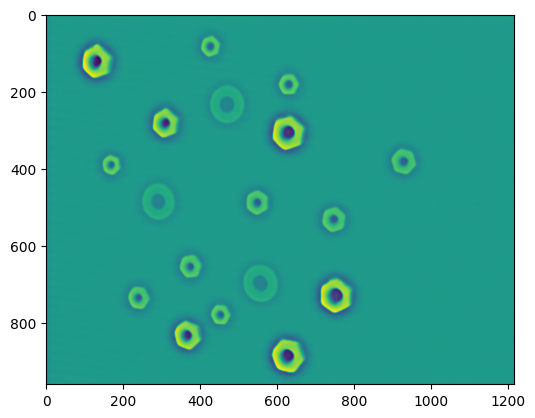

In [ ]:
#@title
train_data = scipy.io.loadmat('/content/drive/MyDrive/Investigacion/Data/MATLAB/3D/reconstruction12.mat')
train_image, XcM, YcM = train_data['Spz'], train_data['XcM'], train_data['YcM']
plt.imshow(train_image)

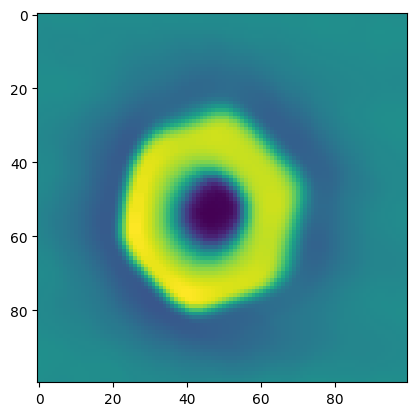

In [ ]:
preprocessor = Preprocessor()
x, y = (380, 30)
Xcrop = preprocessor.crop(XcM, x, y, 100)
Ycrop = preprocessor.crop(YcM, x, y, 100)
Zcrop = preprocessor.crop(train_image, x, y, 100)

plt.imshow(Zcrop)
plt.show()

------------------------------------
# 3D Transformations

In [ ]:
#@title
from ipywidgets import interactive_output, fixed, FloatSlider, HBox, Layout, Button, Label, Output, VBox
import ipywidgets as widgets
from scipy.interpolate import griddata

transformed_images = []

def generate_transformation_matrix(ax, ay, az, tx, ty, tz):
    # Convertimos los ángulos a radianes
    ax=ax*np.pi/180
    ay=ay*np.pi/180
    az=az*np.pi/180

    Rrec = np.array([
        [np.cos(ay)*np.cos(az), np.sin(ax)*np.sin(ay)*np.cos(az)-np.cos(ax)*np.sin(az), np.cos(ax)*np.sin(ay)*np.cos(az)+np.sin(ax)*np.sin(az)],
        [np.cos(ay)*np.sin(az), np.sin(ax)*np.sin(ay)*np.sin(az)+np.cos(ax)*np.cos(az), np.cos(ax)*np.sin(ay)*np.sin(az)-np.sin(ax)*np.cos(az)],
        [-np.sin(ay), np.sin(ax)*np.cos(ay), np.cos(ax)*np.cos(ay)]
    ])
    tras = np.array([tx, ty, tz])
    Mext_rec = np.concatenate((Rrec, tras.reshape(3, 1)), axis=1)
    Mext_rec = np.vstack((Mext_rec, np.array([0,0,0,1])))

    return Mext_rec


def transform_points(Mext_rec, Xcrop, Ycrop, Zcrop):
    xcrop=Xcrop.flatten()
    ycrop=Ycrop.flatten()
    zcrop=Zcrop.flatten()
    P=np.vstack((xcrop,ycrop))
    P=np.vstack((P,zcrop))

    zeros_file=np.zeros(xcrop.shape[0]-1)
    last_file=np.hstack((zeros_file,np.array([1])))

    P=np.vstack((P,last_file))
    P_rot=Mext_rec@P

    # Retornamos las primeras tres filas de P_rot, para la imagen 3D transformada
    return P, P_rot[:3, :]

def plotter(P, P_rot, alpha, phi):
    # Plotting results
    fig = plt.figure(figsize =(12, 6))

    # 3D projection
    ax1 = fig.add_subplot(121, projection ='3d')
    ax1.scatter(P_rot[0,:], P_rot[1,:], P_rot[2,:],c=P[2,:])
    ax1.set_xlabel('X'); 
    ax1.set_ylabel('Y'); 
    ax1.set_zlabel('Z') 
    ax1.view_init(alpha,phi) 
    ax1.axis('equal')

    # 2D projection
    ax2 = fig.add_subplot(122)
    ax2.scatter(P_rot[0,:], P_rot[1,:],c=P[2,:])
    ax2.set_xlabel('X'); 
    ax2.set_ylabel('Y'); 
    ax2.axis('equal')

    plt.show()
  
def on_button_save_clicked(b):
    # Aquí generamos la matriz de transformación extrínseca usando los valores actuales de los deslizadores
    Mext_rec = generate_transformation_matrix(slider_ax.value, slider_ay.value, slider_az.value, 
                                              slider_tx.value, slider_ty.value, slider_tz.value)

    # Transformamos los puntos 3D a una imagen 3D usando la matriz de transformación y las matrices Xcrop, Ycrop y Zcrop
    P, P_rot_3D = transform_points(Mext_rec, Xcrop, Ycrop, Zcrop)

    # Extraemos las coordenadas y los valores de la transformación
    points = P_rot_3D[:2, :].T
    values = P_rot_3D[2, :]

    # Definimos el rango de la nueva imagen
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    xi = np.linspace(x_min, x_max, 500)
    yi = np.linspace(y_min, y_max, 500)
    xi, yi = np.meshgrid(xi, yi)

    # Creamos una imagen rasterizada usando interpolación
    zi = griddata(points, values, (xi, yi), method='linear')

    # Agregamos la imagen transformada a la lista de transformaciones
    transformed_images.append(zi)

    # Actualizamos el contador de transformaciones guardadas
    count_label.value = f'Transformations saved: {len(transformed_images)}'


def on_button_clear_clicked(b):
    # Limpiamos la lista de transformaciones
    transformed_images.clear()

    # Actualizamos el contador de transformaciones guardadas
    count_label.value = f'Transformations saved: {len(transformed_images)}'


# Deslizadores para los ángulos y traslaciones
slider_ax = widgets.IntSlider(min=-90, max=90, step=5, value=0, description='ax')
slider_ay = widgets.IntSlider(min=-90, max=90, step=5, value=0, description='ay')
slider_az = widgets.IntSlider(min=-90, max=90, step=5, value=0, description='az')

slider_tx = widgets.IntSlider(min=-10, max=10, step=1, value=0, description='tx')
slider_ty = widgets.IntSlider(min=-10, max=10, step=1, value=0, description='ty')
slider_tz = widgets.IntSlider(min=-10, max=10, step=1, value=0, description='tz')

# Deslizadores para los ángulos de visualización
slider_alpha = widgets.IntSlider(min=-90, max=90, step=5, value=15, description='alpha')
slider_phi = widgets.IntSlider(min=-90, max=90, step=5, value=0, description='phi')

# Botones para guardar y borrar transformaciones
button_save = Button(description="Guardar")
button_clear = Button(description="Borrar todo")

# Etiqueta para mostrar el número de transformaciones guardadas
count_label = Label(value='Transformations saved: 0')

# Conectar los botones a sus funciones correspondientes
button_save.on_click(on_button_save_clicked)
button_clear.on_click(on_button_clear_clicked)


# Organización de los deslizadores y botones en la interfaz
box_layout = Layout(display='flex', flex_flow='column', align_items='center', width='auto')
controls_angles = VBox([Label(value="Rotation angles"), slider_ax, slider_ay, slider_az], layout=box_layout)
controls_translation = VBox([Label(value="Translations"), slider_tx, slider_ty, slider_tz], layout=box_layout)
controls_view = VBox([Label(value="View angles"), slider_alpha, slider_phi], layout=box_layout)
controls_buttons = VBox([Label(value="Controls"), button_save, button_clear, count_label], layout=box_layout)
ui = HBox([controls_angles, controls_translation, controls_view, controls_buttons])

# Función a la que se llamará cuando se mueva algún deslizador
def output(ax, ay, az, tx, ty, tz, alpha, phi):
    Mext_rec = generate_transformation_matrix(ax, ay, az, tx, ty, tz)
    P, P_rot = transform_points(Mext_rec, Xcrop, Ycrop, Zcrop)
    plotter(P, P_rot, alpha, phi)

# Creación del widget interactivo
out = widgets.interactive_output(output, {'ax': slider_ax, 'ay': slider_ay, 'az': slider_az, 
                                          'tx': slider_tx, 'ty': slider_ty, 'tz': slider_tz, 
                                          'alpha': slider_alpha, 'phi': slider_phi})

display(ui, out)

Output()

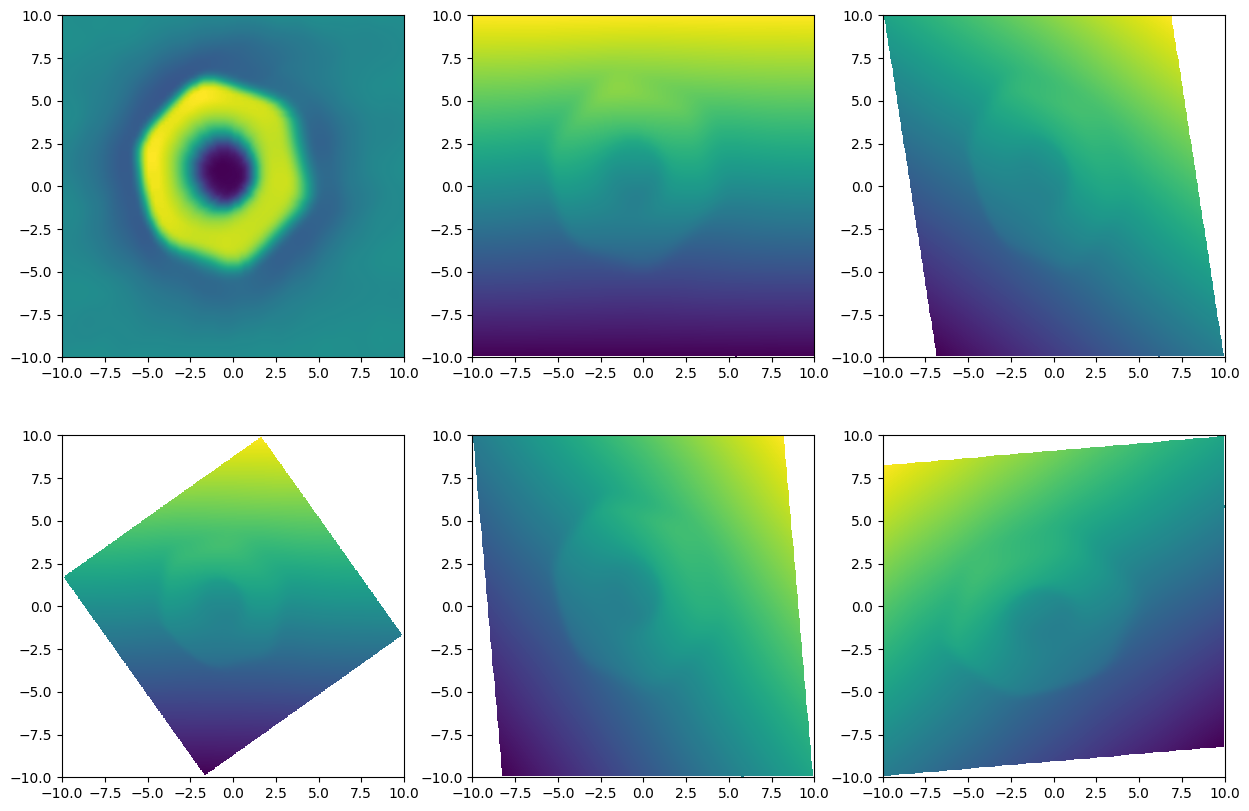

In [ ]:
#@title
def plot_transformations(transformations):
    rows = len(transformations) // 3 + (len(transformations) % 3 > 0)  # Calculamos el número de filas necesarias
    cols = min(3, len(transformations))  # No queremos más de 3 columnas
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    if rows > 1 or cols > 1:
        axes = axes.flatten()  # Si tenemos más de un subplot, necesitamos aplanar el array de ejes

    for ax, transformation in zip(axes, transformations):
        # Mostramos la imagen
        im = ax.imshow(transformation, extent=(-10, 10, -10, 10), origin='lower')

    plt.show()

plot_transformations(transformed_images)

####Note: The size of the axes has changed only for visualization(-10.0 to 10.0).

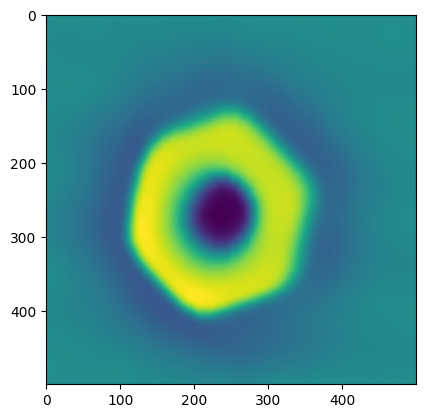

In [ ]:
plt.imshow(transformed_images[0])

# Model Training

In [ ]:
size_object = 100 # 100
wide = 20 # size of the training template
downsample = size_object // wide

###Option 1: Same 2D transformations

In [ ]:
#@title
transformations = (
    #Add:  dt.ElasticTransformation
    dt.Affine(scale=lambda:np.random.uniform(0.8, 1.5, 2), translate=lambda:np.random.uniform(-1.5, 1.5, 2), rotate=lambda: np.random.rand()*np.pi*2),
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)), # Very sensitive
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2)) # 0.3, 1.6
)

###Option 2: Some 2D transformations

In [ ]:
transformations = (
    #Add:  dt.ElasticTransformation
    dt.Affine(translate=lambda:np.random.uniform(-1.5, 1.5, 2), rotate=lambda: np.random.rand()*np.pi*2),
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)), # Very sensitive
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2)) # 0.3, 1.6
)

In [ ]:
proof = [transformed_images[0]]
proof

[array([ 0.0194894 ,  0.0194894 ,  0.0194894 ,  0.0194894 ,  0.0194894 ,
         0.0194894 ,  0.02096067,  0.02249389,  0.0240271 ,  0.02556032,
         0.02709353,  0.02858671,  0.03007637,  0.03156603,  0.03305569,
         0.03454535,  0.03472591,  0.03472591,  0.03472591,  0.03472591,
         0.03472591,  0.03367767,  0.03242736,  0.03117705,  0.02992674,
         0.02867643,  0.02795142,  0.0273594 ,  0.02676738,  0.02617536,
         0.02558334,  0.02519269,  0.02486647,  0.02454025,  0.02421403,
         0.02388782,  0.02382133,  0.02385727,  0.02389322,  0.02392916,
         0.0239651 ,  0.02417317,  0.02446344,  0.02475372,  0.02504399,
         0.02533426,  0.02560171,  0.02585611,  0.02611052,  0.02636492,
         0.02661932,  0.02672211,  0.02672211,  0.02672211,  0.02672211,
         0.02672211,  0.02634319,  0.02566114,  0.02497908,  0.02429703,
         0.02361497,  0.02268069,  0.02150901,  0.02033733,  0.01916565,
         0.01799397,  0.01665297,  0.01512462,  0.0

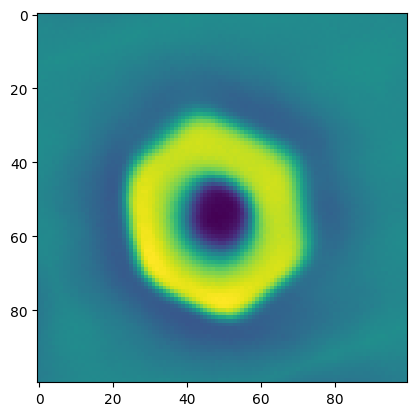

In [ ]:
train_set = preprocessor.create_train_data([transformed_images[0]], transformations)

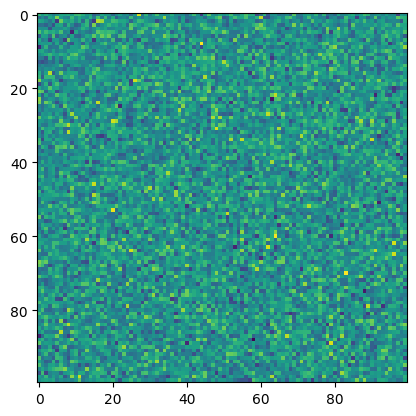

In [ ]:
image = train_set.update()()
plt.imshow(image)

In [ ]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/3D_transformations'
trainer = Trainer(filepath)

In [ ]:
history = trainer.fit(train_set, epochs=30)

Generating 160 / 160 samples before starting training
Epoch 1/30
160/160 [==============================] - 75s 366ms/step - total_loss: 22.8227 - consistency_loss: 19.7076 - lr: 0.0010
Epoch 2/30
160/160 [==============================] - 96s 600ms/step - total_loss: 21.5225 - consistency_loss: 20.0003 - lr: 0.0010   
Epoch 3/30
160/160 [==============================] - 141s 884ms/step - total_loss: 21.3787 - consistency_loss: 19.6758 - lr: 0.0010                          
Epoch 4/30
160/160 [==============================] - 150s 942ms/step - total_loss: 21.0622 - consistency_loss: 19.0620 - lr: 0.0010                          
Epoch 5/30
160/160 [==============================] - 137s 860ms/step - total_loss: 20.0295 - consistency_loss: 18.2294 - lr: 0.0010                         
Epoch 6/30
160/160 [==============================] - 140s 877ms/step - total_loss: 21.4591 - consistency_loss: 19.5317 - lr: 0.0010                          
Epoch 7/30
160/160 [========================

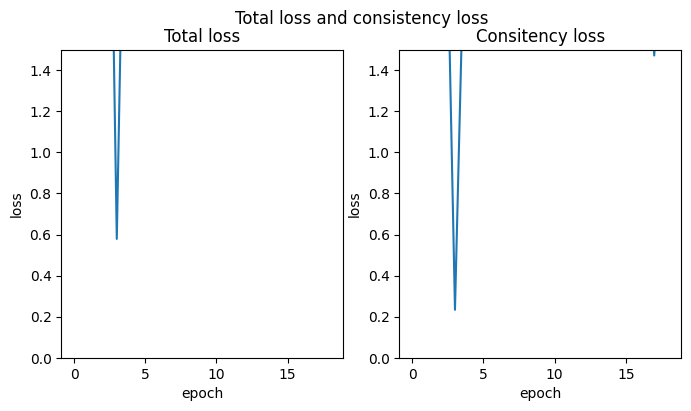

In [ ]:
trainer.plot_performance(history)

In [ ]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/3D_transformations'
trainer = Trainer(filepath)
trainer.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
trainer.model.load_weights(filepath)